In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
#!pip install -q efficientnet

In [8]:
# Importing Necessary Libraries
%matplotlib inline
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from collections import Counter
from tensorflow.keras import applications as efn
import re
from tensorflow.keras import layers as L
import sklearn

sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,8)})

In [9]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [10]:
# Reading the dataset
dataset = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
dataset

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


# SIIM-ISIC Melanoma Classification

## Data Exploration

In [11]:
dataset.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [12]:
dataset.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [13]:
dataset.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [15]:
dataset.nunique()

image_name                       33126
patient_id                        2056
sex                                  2
age_approx                          18
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
target                               2
dtype: int64

## Data Visualisations

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='benign_malignant', ylabel='count'>

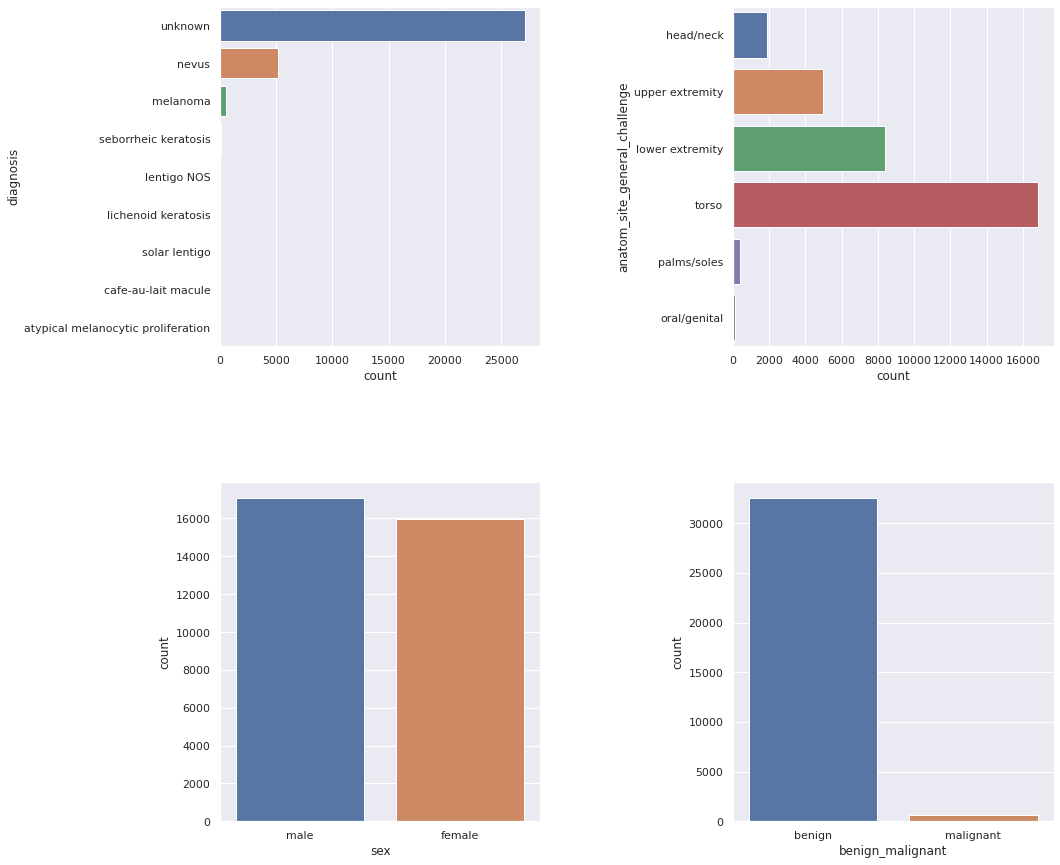

In [16]:
f, axes = plt.subplots(2, 2, figsize=(12,12))
f.tight_layout() 
plt.subplots_adjust(left=0.01, wspace=0.6, hspace=0.4)
sns.countplot(y="anatom_site_general_challenge", data=dataset,  ax=axes[0][1])
sns.countplot(y="diagnosis", data=dataset,  ax=axes[0][0])
sns.countplot(x='sex', data=dataset, ax=axes[1][0])
sns.countplot("benign_malignant", data=dataset,  ax=axes[1][1])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_approx', ylabel='Density'>

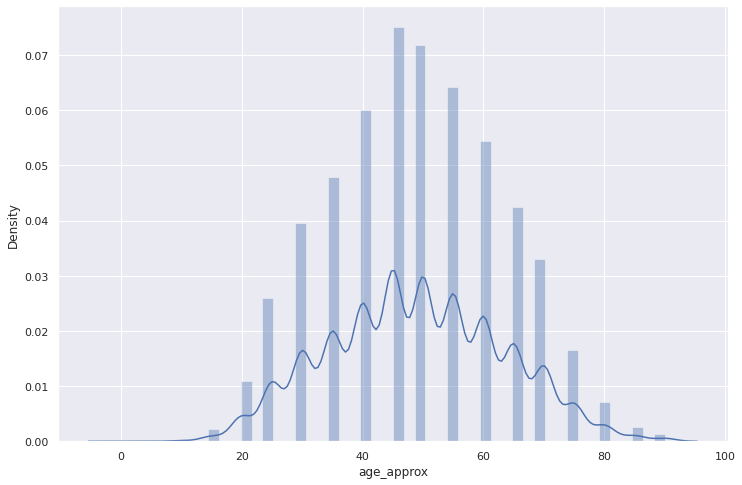

In [17]:
sns.distplot(dataset['age_approx'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

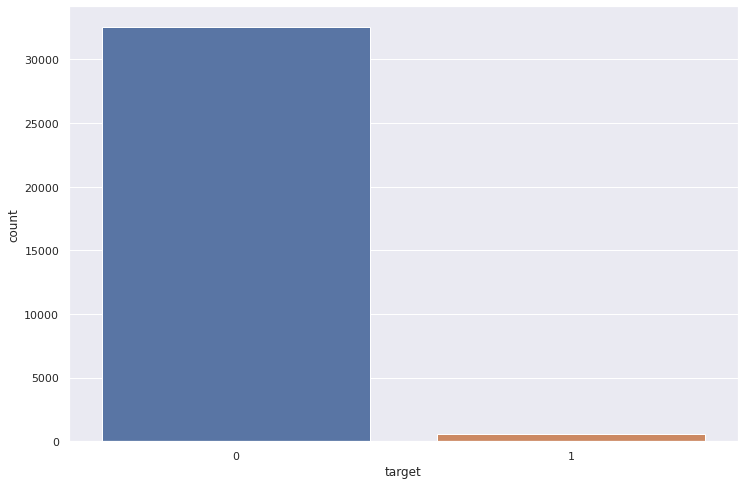

In [18]:
sns.countplot("target", data=dataset)

In [19]:
dataset['target'].value_counts(normalize=True) * 10

0    9.823703
1    0.176297
Name: target, dtype: float64

> **IMBALANCED DATASET!**

# Images Visualisations

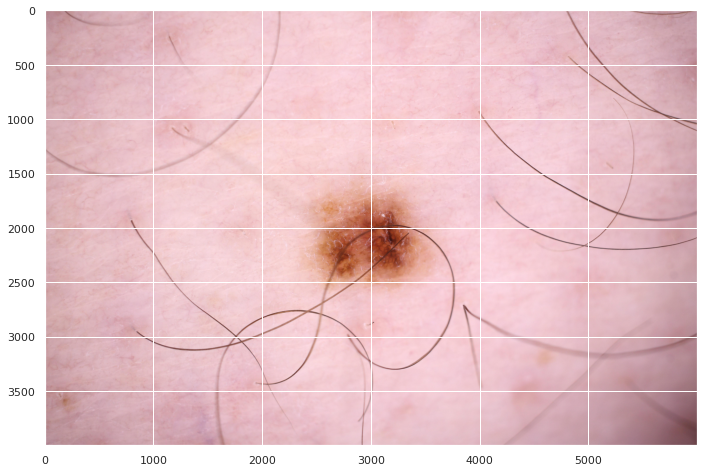

In [20]:
# Showing a sample image
image = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_5766923.jpg')
plt.imshow(image)

## Benign Images

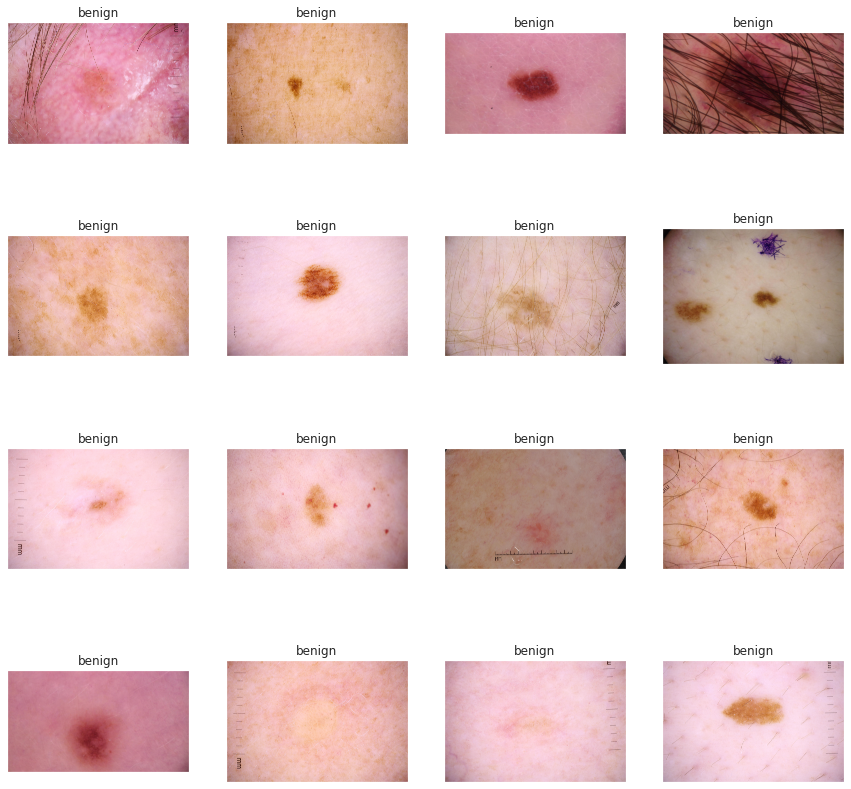

In [21]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+dataset['image_name'][i]+'.jpg')
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(dataset['benign_malignant'][i])  # set title
    plt.imshow(img)



plt.show()  # finally, render the plot

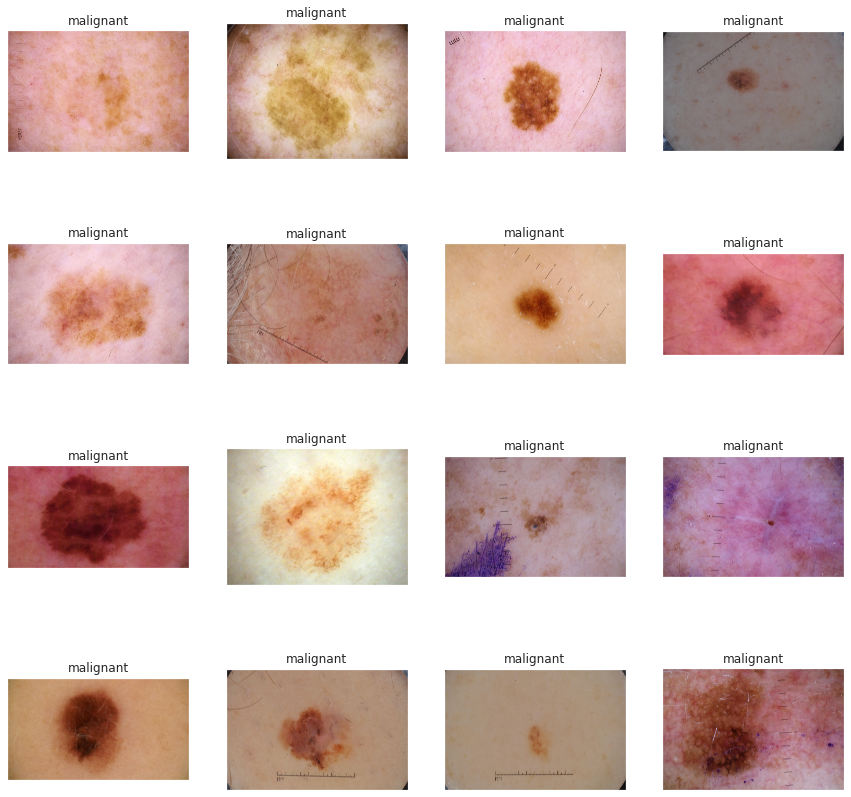

In [22]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+dataset.loc[dataset['target'] == 1]['image_name'].values[i]+'.jpg')
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(dataset.loc[dataset['target'] == 1]['benign_malignant'].values[i])  # set title
    plt.imshow(img)



plt.show()  # finally, render the plot

# Cleaning Dataset

## Removing NaN values

In [23]:
dataset.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [24]:
dataset.loc[dataset.isnull().any(axis=1)]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33,ISIC_0086462,IP_3200260,female,30.0,NaN,unknown,benign,0
38,ISIC_0088137,IP_5205991,NaN,NaN,lower extremity,unknown,benign,0
61,ISIC_0099474,IP_3057277,male,45.0,NaN,unknown,benign,0
188,ISIC_0174903,IP_2760044,male,40.0,NaN,unknown,benign,0
200,ISIC_0178744,IP_4248414,male,25.0,NaN,unknown,benign,0
...,...,...,...,...,...,...,...,...
32898,ISIC_9928421,IP_0961415,male,45.0,NaN,unknown,benign,0
33001,ISIC_9963692,IP_6017204,female,35.0,NaN,unknown,benign,0
33025,ISIC_9971473,IP_1005683,male,70.0,NaN,unknown,benign,0
33041,ISIC_9975949,IP_9245079,male,40.0,NaN,nevus,benign,0


In my case, i will remove the rows with nan values, let's first try to train model with real dataset with no filled NaN value. 

In [25]:
dataset = dataset.dropna(axis=0)
dataset.isnull().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

## Changing all column into categorical

In [26]:
cleaned_dataset = dataset.copy()
cleaned_dataset

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [27]:
cleaned_dataset.sex = cleaned_dataset.sex.replace({'male':0, 'female':1})
cleaned_dataset = cleaned_dataset.join(pd.get_dummies(cleaned_dataset.anatom_site_general_challenge))
cleaned_dataset = cleaned_dataset.join(pd.get_dummies(cleaned_dataset.diagnosis))

In [28]:
pd.options.display.max_rows = 999
cleaned_dataset = cleaned_dataset.reset_index()
cleaned_dataset.head(35)

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,head/neck,...,upper extremity,atypical melanocytic proliferation,cafe-au-lait macule,lentigo NOS,lichenoid keratosis,melanoma,nevus,seborrheic keratosis,solar lentigo,unknown
0,0,ISIC_2637011,IP_7279968,0,45.0,head/neck,unknown,benign,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,ISIC_0015719,IP_3075186,1,45.0,upper extremity,unknown,benign,0,0,...,1,0,0,0,0,0,0,0,0,1
2,2,ISIC_0052212,IP_2842074,1,50.0,lower extremity,nevus,benign,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,ISIC_0068279,IP_6890425,1,45.0,head/neck,unknown,benign,0,1,...,0,0,0,0,0,0,0,0,0,1
4,4,ISIC_0074268,IP_8723313,1,55.0,upper extremity,unknown,benign,0,0,...,1,0,0,0,0,0,0,0,0,1
5,5,ISIC_0074311,IP_2950485,1,40.0,lower extremity,unknown,benign,0,0,...,0,0,0,0,0,0,0,0,0,1
6,6,ISIC_0074542,IP_4698288,0,25.0,lower extremity,unknown,benign,0,0,...,0,0,0,0,0,0,0,0,0,1
7,7,ISIC_0075663,IP_6017204,1,35.0,torso,unknown,benign,0,0,...,0,0,0,0,0,0,0,0,0,1
8,8,ISIC_0075914,IP_7622888,0,30.0,torso,unknown,benign,0,0,...,0,0,0,0,0,0,0,0,0,1
9,9,ISIC_0076262,IP_5075533,1,50.0,lower extremity,unknown,benign,0,0,...,0,0,0,0,0,0,0,0,0,1


# Creating the Training & Testing Dataset

A special thanks to AjayKumar for providing much an awesome [Kaggle Notebook](https://www.kaggle.com/ajaykumar7778/melanoma-tpu-efficientnet-b5-dense-head) that helped me a lot to get started with `tf.data`

In [29]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

In [30]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

CLASSES = [0,1]   
IMAGE_SIZE = [1024, 1024]
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [31]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
       
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images and {} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_TEST_IMAGES))

Dataset: 33126 training images and 10982 unlabeled test images


In [32]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
EPOCHS = 5

In [33]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [34]:
with strategy.scope():
    xception_model = tf.keras.Sequential([
        efn.Xception(
            input_shape=(*IMAGE_SIZE, 3),
            #weights='imagenet',
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
#         L.Dense(1024, activation = 'relu'), 
#         L.Dropout(0.3), 
#         L.Dense(512, activation= 'relu'), 
#         L.Dropout(0.2), 
#         L.Dense(256, activation='relu'), 
#         L.Dropout(0.2), 
#         L.Dense(128, activation='relu'), 
#         L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
    ])

83689472/83683744 [==============================] - 1s 0us/step


In [35]:
from tensorflow.keras import backend as K

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [36]:
xception_model.compile(
    optimizer='adam',
    loss = focal_loss(gamma=2., alpha=.25),
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    metrics=['binary_crossentropy', 'accuracy']
)
xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 32, 32, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [37]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [38]:
#model.load_weights('../input/melenoma/model_weights.h5')

In [39]:
history = xception_model.fit(
    get_training_dataset(), 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_schedule]#,
#     class_weight = {0:0.50899675,1: 28.28782609}
)

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
517/517 [==============================] - 424s 716ms/step - loss: 0.0371 - binary_crossentropy: 0.3316 - accuracy: 0.9206
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 4.95e-05.
517/517 [==============================] - 366s 708ms/step - loss: 0.0074 - binary_crossentropy: 0.1427 - accuracy: 0.9822
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 8.9e-05.
517/517 [==============================] - 365s 706ms/step - loss: 0.0070 - binary_crossentropy: 0.1317 - accuracy: 0.9820
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001285.
517/517 [==============================] - 366s 708ms/step - loss: 0.0069 - binary_crossentropy: 0.1237 - accuracy: 0.9817
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000168.
517/517 [==============================] - 365s 706ms/step - loss: 0.0063 - binary_crossentropy: 0.11

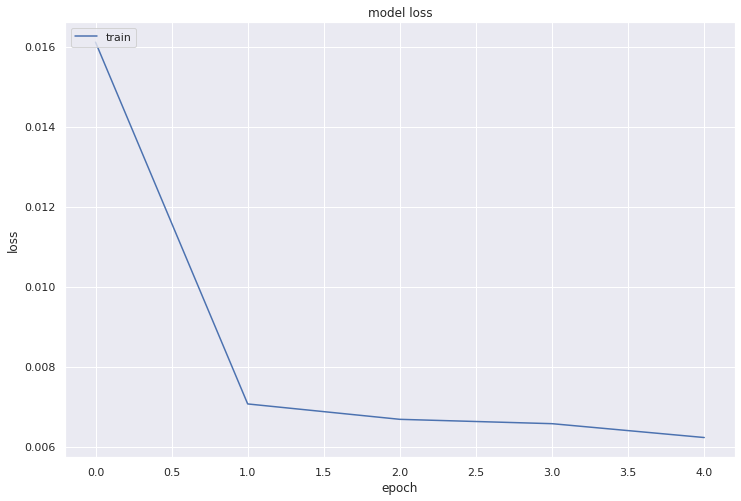

In [40]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

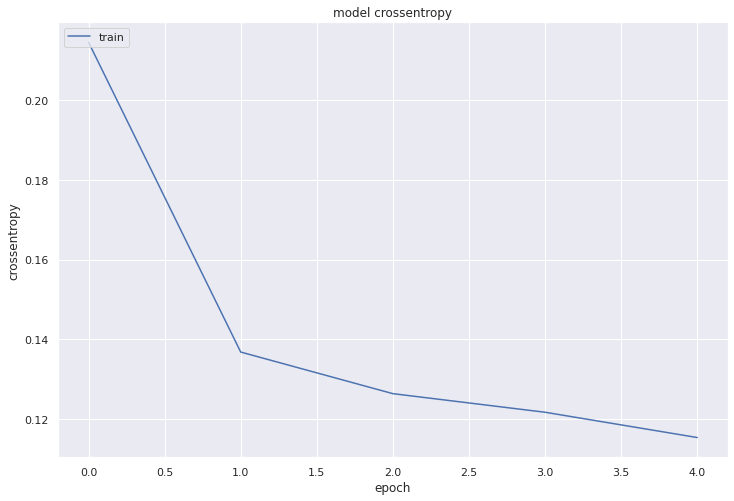

In [41]:
# summarize history for loss
plt.plot(history.history['binary_crossentropy'])
plt.title('model crossentropy')
plt.ylabel('crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
xception_model.save('complete_data_xception_model.h5')

In [43]:
xception_model.save_weights('complete_data_exception_model_weights.h5')

# Generating the Predictions

In [44]:
test_ds = get_test_dataset(ordered=True)
test_images_ds = test_ds.map(lambda image, idnum: image)

In [45]:
probabilities = xception_model.predict(test_images_ds)

In [46]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

Generating submission.csv file...


In [47]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_6381819,0.168566
1,ISIC_5583376,0.134718
2,ISIC_6408546,0.054652
3,ISIC_6932354,0.170614
4,ISIC_8191278,0.120796


In [48]:
sub = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
sub

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0
...,...,...
10977,ISIC_9992485,0
10978,ISIC_9996992,0
10979,ISIC_9997917,0
10980,ISIC_9998234,0


In [49]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
#sub.to_csv('submission_label_smoothing.csv', index=False)
sub.to_csv('complete_data.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.053978
1,ISIC_0052349,0.046375
2,ISIC_0058510,0.050901
3,ISIC_0073313,0.028605
4,ISIC_0073502,0.179356


## Single Image Prediction

In [50]:
import PIL
from PIL import Image

In [51]:
idx = 459
print(cleaned_dataset['image_name'][idx])
img = Image.open('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/' + cleaned_dataset['image_name'][idx]+'.jpg')

ISIC_0249269


In [52]:
img = img.resize((1024, 1024), PIL.Image.ANTIALIAS)

In [53]:
img = np.array(img)
img = img/255.0

In [54]:
img = img[np.newaxis, ...]
img.shape

(1, 1024, 1024, 3)

In [55]:
xception_model.predict(img)

array([[0.07588401]], dtype=float32)

In [56]:
img = Image.open('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_7939816.jpg')

In [57]:
img = img.resize((1024, 1024), PIL.Image.ANTIALIAS)
img = np.array(img)
img = img/255.0
img = img[np.newaxis, ...]
img.shape

(1, 1024, 1024, 3)

In [58]:
xception_model.predict(img)

array([[0.28207254]], dtype=float32)

In [60]:
imgAtharva = Image.open('../input/test-image/1625336728963.jpg')

In [61]:
imgAtharva = imgAtharva.resize((1024, 1024), PIL.Image.ANTIALIAS)

In [62]:
imgAtharva = np.array(imgAtharva)
imgAtharva = imgAtharva/255.0

In [63]:
imgAtharva = imgAtharva[np.newaxis, ...]
imgAtharva.shape

(1, 1024, 1024, 3)

In [64]:
xception_model.predict(imgAtharva)

array([[0.07712814]], dtype=float32)